In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from torchvision import transforms
import os 
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np 

## Visualization
The landscape dataset is an unlabeled set of landscape images. The creators of the dataset further sorted the images by their likeliehood.'That's why images with smaller idx are much more noisy.'
1. Create a dataframe.
2. Plot images from top, middle, bottom of dataset to visualize difference in likeliehood. 
3. In conclusion: The first images can be seen as outliers. Skipping the first n images leads to a trade-off between a larger dataset and a dataset with less variance.

In [4]:
fpath = "./data/lhq_256/"
#fpath = "~/pytorch_datasets/lhq_256/"
ext = ".png"
file_list = []
for root, dirs, files in os.walk(fpath, topdown=False):
    for name in sorted(files):
        file_list.append(os.path.join(root, name))

df = pd.DataFrame({"Filepath":file_list},)
df = df[df["Filepath"].str.endswith(ext)] # Avoid having other files than png files in Dataframe
df.head()

Filepath
0  ./data/lhq_256/0000000.png
1  ./data/lhq_256/0000001.png
2  ./data/lhq_256/0000002.png
3  ./data/lhq_256/0000003.png
4  ./data/lhq_256/0000004.png

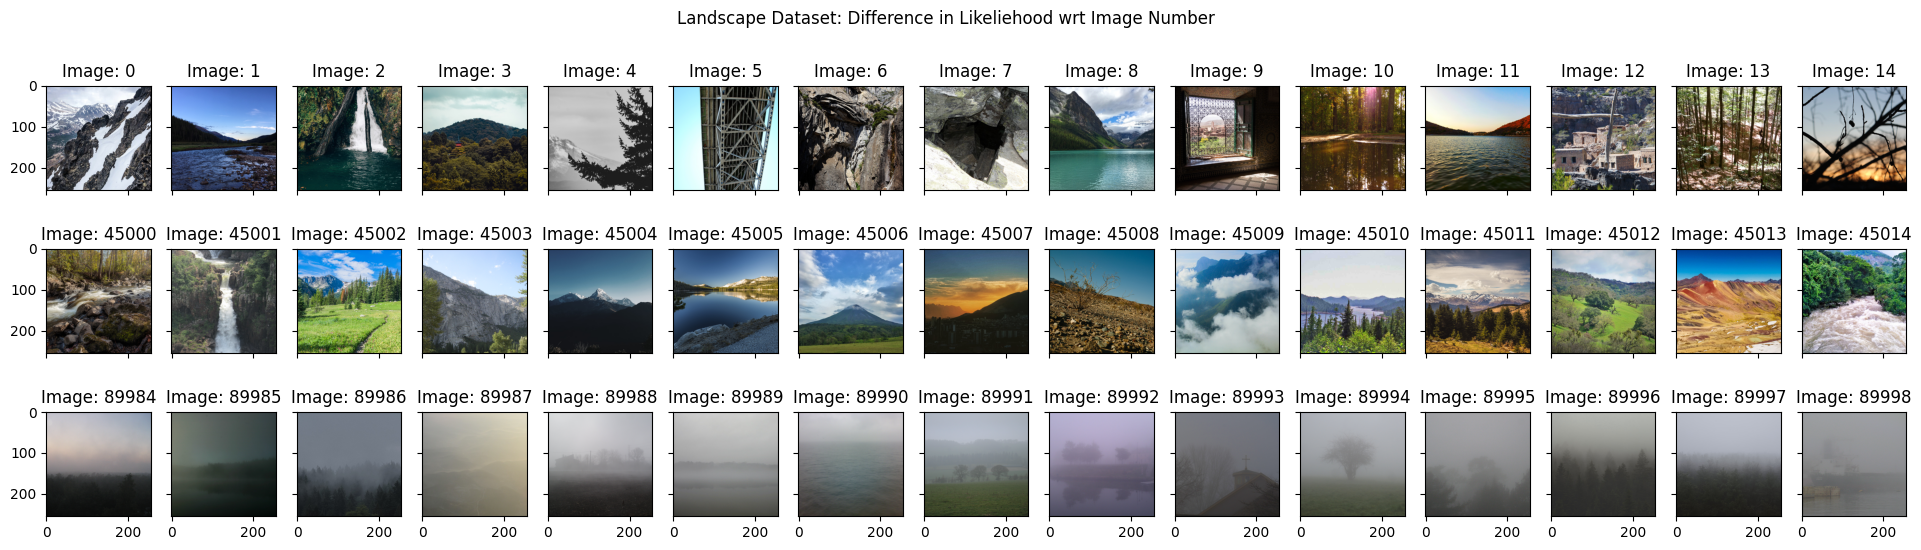

In [5]:
df_size = len(df)
row_len = 15
fig, (ax1,ax2,ax3) = plt.subplots(3,row_len,figsize=(24,6),clear=True,sharex=True,sharey=True)
fig.suptitle("Landscape Dataset: Difference in Likeliehood wrt Image Number")

for i in range(row_len):
    
    image1 = Image.open(df.iloc[i].Filepath)
    image2 = Image.open(df.iloc[i+df_size//2].Filepath)
    image3 = Image.open(df.iloc[df_size-row_len-1+i].Filepath)
    
    ax1[i].imshow(image1)
    ax2[i].imshow(image2)
    ax3[i].imshow(image3)

    ax1[i].set_title(f"Image: {i}")
    ax2[i].set_title(f"Image: {i+df_size//2}")
    ax3[i].set_title(f"Image: {df_size-row_len-1+i}")
    


## Creating a Dataloader 

1. For diffusion models the pixel values of the training data have to be scaled to lay inbetween (-1,1) instead of (0,255) -> this can be solved with transforms.normalize()
2. colour jittering and cropping(which leads to black borders) should be avoided since the model will be used for image generation afterwards. 
3. The images have to be resized. Either by cropping or rescaling. Downscaling the image 256 -> 64 seems to be the better solution since cropping out leads to only a fourth of the initial image which is in most cases not representing a larger landscape anymore. 
4. Random vertical flips seem to be the best augmentation method since the landscape still remains realistic. 

/usr/local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


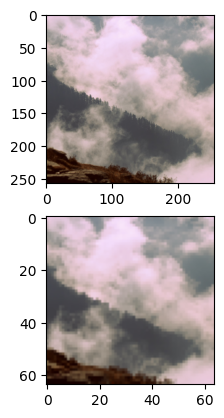

In [6]:
image_num = len(df)//2 + len(df)//4

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(64),transforms.RandomHorizontalFlip(p=0.5)])
back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()]) # Just for plotting

path = df.iloc[image_num].Filepath
fig,ax1 = plt.subplots(2)
ax1[0].imshow(Image.open(path))
ax1[1].imshow(back2pil(transform(Image.open(path))))


## Building the Dataloader
1. The dataloader should be able to create two non overlapping subsets that can be used as test and train sets. Additionally the fraction should be variable.
2. further the transformation and the skipping of the first n images should be possible as well. 


In [8]:
# Demo of stratifying data 
df1 = pd.DataFrame(np.arange(9))
df_train = df1.sample(frac=0.5,random_state=2)
df_test = df1.drop(df_train.index)


#later: 
df_train1 = df1.sample(frac=0.5,random_state=2)
df_test = df1.drop(df_train1.index)


print(f"df before {df1}")
print(f"df train {df_train}")
print(f"df test{df_test}")

df before    0
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
df train    0
4  4
1  1
6  6
2  2
df test   0
0  0
3  3
5  5
7  7
8  8


In [6]:
class UnconditionalDataset(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string): Path to the folder where images are stored
            img_size (int): size of output image img_size=height=width
            ext (string): type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            skip_first_n: skips the first n values. Usefull for datasets that are sorted by increasing Likeliehood 
            train (Bool): Choose dataset to be either train set or test set. frac(float) required 
            frac (float): value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
                            """

        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
        
        
            
        if skip_first_n:
            self.df = self.df[skip_first_n:]
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test
            
        if transform: 
            self.transform =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(img_size),transforms.RandomHorizontalFlip(p=0.5)])
        else : 
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        return self.transform(img)
        

In [7]:
trainset = UnconditionalDataset(fpath = "./data/lhq_256/",img_size=64,train=True ,frac =0.8,skip_first_n = 0,ext = ".png",transform=True)
testset  = UnconditionalDataset(fpath = "./data/lhq_256/",img_size=64,train=False,frac =0.8,skip_first_n = 0,ext = ".png",transform=True)

print(trainset.__len__())
print(testset.__len__())

72000
18000


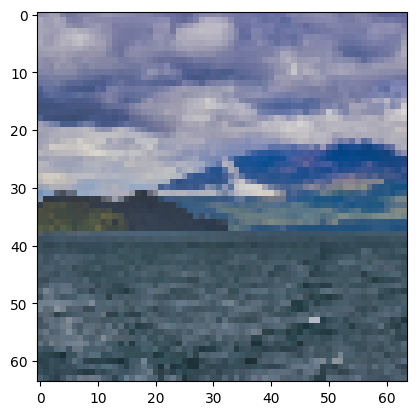

In [8]:
example = trainset.__getitem__(6)
plt.imshow(back2pil(example))

# Further Augmentation:
To further augment the dataset, we want to introduce cropping with random tilts. However, it should be avoided to go outside of the image since padding might disturb image generation. 
What we want to do is either  random crop from the image **OR** centercrop with a random tilt:
1. random crop such that no padding is needed

**OR**

1. Downscale initial Image to a intermediate resolution, above the desired resolution. 
2. Do a center crop with desired resolution and random rotation. 
Assume A = intermediate resolution, a = desired resolution with A>a
the maximum rotation in both directions can be calculated as theta= pi/4 - arccos( A/(sqrt(2)*a))




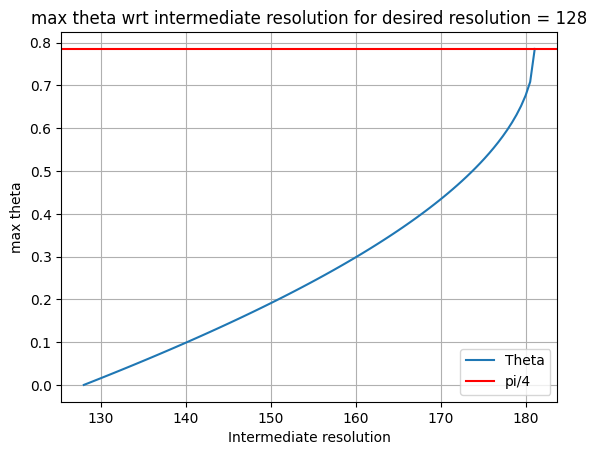

In [40]:
import numpy as np
import matplotlib.pyplot as plt
outres = 128 
A = np.linspace(start=outres,stop=np.sqrt(2)*outres,num=100)
argument = A/(np.sqrt(2)*outres)
theta = np.pi/4 -np.arccos(argument)
plt.plot(A,theta,label="Theta")
plt.title("max theta wrt intermediate resolution for desired resolution = 128")
plt.ylabel("max theta")
plt.xlabel("Intermediate resolution")
plt.axhline(np.pi/4,color="r",label="pi/4")
plt.grid()
plt.legend()


## Checking augmentations 

In [71]:
A = 150
outres = 128
argument = A/(np.sqrt(2)*outres)
theta = np.pi/4 -np.arccos(argument)


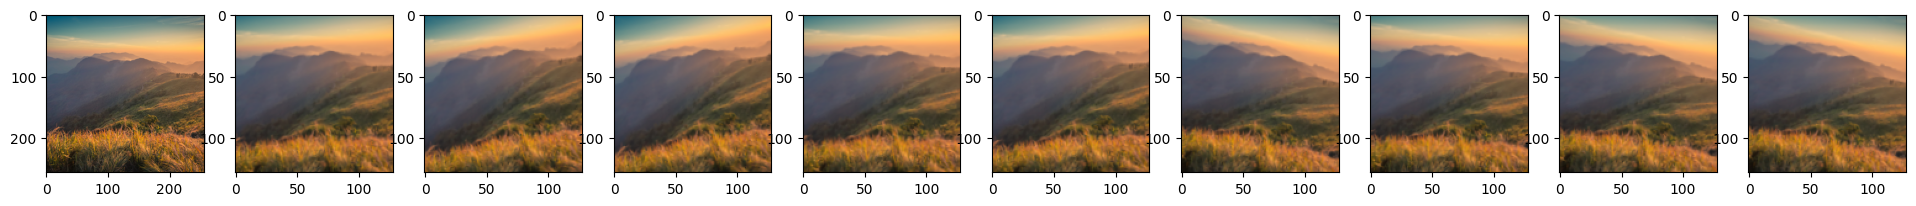

In [97]:

transform_noflip =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(A,antialias=True),transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),transforms.CenterCrop(outres),transforms.RandomHorizontalFlip(p=0.0)])

# Bilinear interpolation is way smoother than the default NEAREST!!!!
image_num = len(df)//2 + len(df)//4+1
path = df.iloc[image_num].Filepath
fig,ax1 = plt.subplots(1,10,figsize=(24,6))
ax1[0].imshow(Image.open(path))
for i in range(1,10):
    ax1[i].imshow(back2pil(transform_noflip(Image.open(path))))



/usr/local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


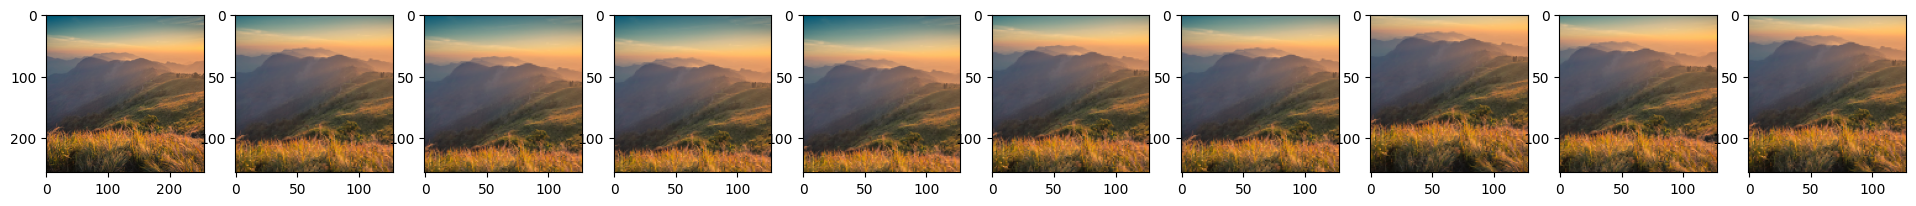

In [98]:
transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(A),transforms.RandomCrop(outres),transforms.RandomHorizontalFlip(p=0.0)])

image_num = len(df)//2 + len(df)//4+1
path = df.iloc[image_num].Filepath
fig,ax1 = plt.subplots(1,10,figsize=(24,8))
ax1[0].imshow(Image.open(path))
for i in range(1,10):
    ax1[i].imshow(back2pil(transform_randomcrop(Image.open(path))))
    

/usr/local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


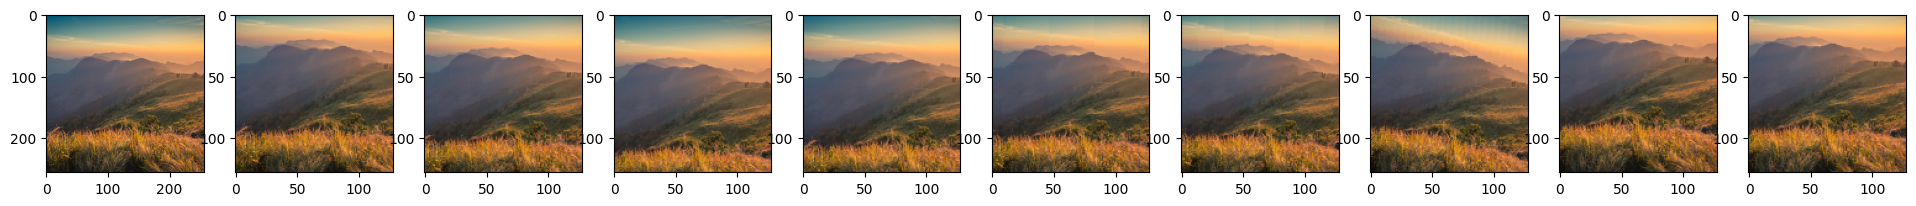

In [92]:
transform_both = transforms.RandomChoice([transform_noflip,transform_randomcrop])

image_num = len(df)//2 + len(df)//4+1
path = df.iloc[image_num].Filepath
fig,ax1 = plt.subplots(1,10,figsize=(24,8))
ax1[0].imshow(Image.open(path))
for i in range(1,10):
    ax1[i].imshow(back2pil(transform_both(Image.open(path))))

## Thus new dataset for Landscapes

In [ ]:
class UnconditionalDataset(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True ):
        """
        Args:
            fpath (string): Path to the folder where images are stored
            img_size (int): size of output image img_size=height=width
            ext (string): type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            skip_first_n: skips the first n values. Usefull for datasets that are sorted by increasing Likeliehood 
            train (Bool): Choose dataset to be either train set or test set. frac(float) required 
            frac (float): value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
                            """

        ### Create DataFrame
        file_list = []
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))

        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)] 
            
        if skip_first_n:
            self.df = self.df[skip_first_n:]
        
        if train: 
            df_train = self.df.sample(frac=frac,random_state=2)
            self.df = df_train
        else:
            df_train = self.df.sample(frac=frac,random_state=2)
            df_test = df.drop(df_train.index)
            self.df = df_test
            
        if transform: 
            intermediate_size = 150
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*outres)) #Check dataloading.ipynb in analysis-depot for more details
            
            transform_rotate =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(intermediate_size,antialias=True),
                                transforms.RandomRotation(theta/np.pi*180,interpolation=transforms.InterpolationMode.BILINEAR),
                                transforms.CenterCrop(img_size),transforms.RandomHorizontalFlip(p=0.5)])
            
            transform_randomcrop  =  transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),
                                transforms.Resize(intermediate_size),transforms.RandomCrop(img_size),transforms.RandomHorizontalFlip(p=0.5)])

            self.transform =  transforms.RandomChoice([transform_rotate,transform_randomcrop])
        else : 
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        return self.transform(img)
        

## New dataset for Celebrity Faces

We additionally train our unconditional diffusion model on the celebrity (CelebAHQ) dataset, whose dataset class looks as follows:

In [12]:
# Dataset used when training on CelebAHQ.    
class UnconditionalDataset_CelebAHQ(Dataset):
    def __init__(self,fpath,img_size,train,frac =0.8,skip_first_n = 0,ext = ".png",transform=True):
        """
        Args:
            fpath (string):   Path to the folder where images are stored
            img_size (int):   Size of output image img_size=height=width
            ext (string):     Type of images used(eg .png)
            transform (Bool): Image augmentation for diffusion model
            skip_first_n:     Skips the first n values. Usefull for datasets that are sorted by increasing Likeliehood 
            train (Bool):     Choose dataset to be either train set or test set. frac(float) required 
            frac (float):     Value within (0,1] (seeded)random shuffles dataset, then divides into train and test set. 
        """
        # they provide a fixed train and validation split
        if train:
            fpath = os.path.join(fpath, 'train') 
        else:
            fpath = os.path.join(fpath, 'valid')

        file_list =[]
        for root, dirs, files in os.walk(fpath, topdown=False):
            for name in sorted(files):
                file_list.append(os.path.join(root, name))
        df = pd.DataFrame({"Filepath":file_list},)
        self.df = df[df["Filepath"].str.endswith(ext)]
            
        if transform: 
            intermediate_size = 137
            theta = np.pi/4 -np.arccos(intermediate_size/(np.sqrt(2)*img_size)) #Check dataloading.ipynb in analysis-depot for more details
             
            transform_rotate_flip =  transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(intermediate_size,antialias=True),
                                     transforms.RandomRotation((theta/np.pi*180),interpolation=transforms.InterpolationMode.BILINEAR),
                                     transforms.CenterCrop(img_size),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            transform_flip =  transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(img_size, antialias=True),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

            self.transform =  transforms.RandomChoice([transform_rotate_flip,transform_flip])                                                   
        else :
            self.transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(img_size)])
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        path =  self.df.iloc[idx].Filepath
        img = Image.open(path)
        return self.transform(img),0
        
    def tensor2PIL(self,img):
        back2pil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
        return back2pil(img)


The key differences are that since we are dealing with centered faces, random cropping should be changed to center cropping, while the intermediate size has been reduced from 150px to 137px in order to keep the complete face of the celebrity as part of the image. This also causes us to apply smaller amounts of rotations, randomly drawn between 0 and 4.2 degrees.

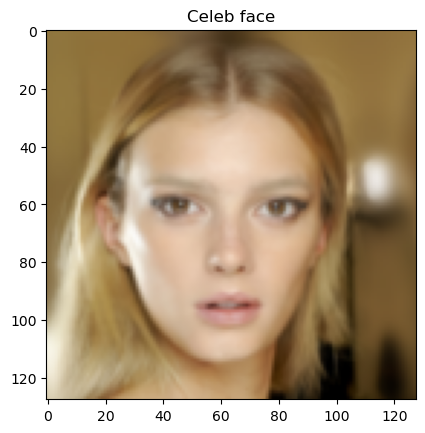

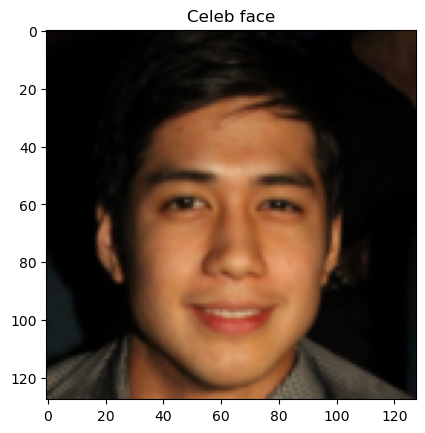

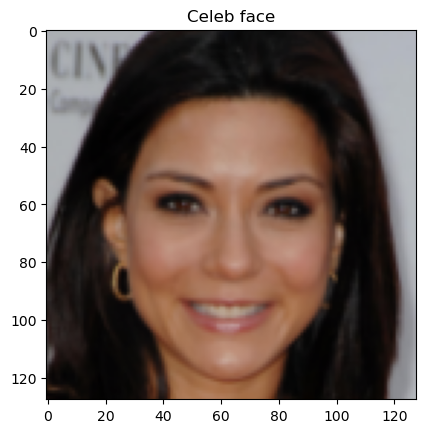

In [10]:
fpath = "/Users/gonzalo/Desktop/chq_256/"
batch_size = 3
celeb_ds = UnconditionalDataset_CelebAHQ(fpath=fpath,img_size=128,frac =0.8,skip_first_n = 0,ext = ".png",
                                          transform=True, train = True)
celeb_loader = torch.utils.data.DataLoader(celeb_ds,batch_size=batch_size, shuffle=True)
for idx, (x_0, _) in enumerate(celeb_loader):
    for i in range(x_0.shape[0]):
        x_0_pil = celeb_ds.tensor2PIL(x_0[i])
        fig, ax = plt.subplots()
        ax.imshow(x_0_pil)
        ax.set_title('Celeb face')
        plt.show()
    break